In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Vertex AI Model Garden - LayoutML Document QA

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/model_garden/model_garden_pytorch_layoutml_document_qa.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/model_garden/model_garden_pytorch_layoutml_document_qa.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/notebooks/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/notebooks/community/model_garden/model_garden_pytorch_layoutml_document_qa.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
Open in Vertex AI Workbench
    </a>
    (a Python-3 CPU notebook is recommended)
  </td>
</table>

## Overview

This notebook demonstrates deploying the pre-trained [LayoutML](https://huggingface.co/impira/layoutlm-document-qa) model on Vertex AI for online prediction.

### Objective

- Upload the model to [Model Registry](https://cloud.google.com/vertex-ai/docs/model-registry/introduction).
- Deploy the model on [Endpoint](https://cloud.google.com/vertex-ai/docs/predictions/using-private-endpoints).
- Run online predictions for image captioning.

### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing) and [Cloud Storage pricing](https://cloud.google.com/storage/pricing), and use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.

## Setup environment

**NOTE**: Jupyter runs lines prefixed with `!` as shell commands, and it interpolates Python variables prefixed with `$` into these commands.

### Colab only

In [ ]:
!pip3 install --upgrade google-cloud-aiplatform

In [2]:
from google.colab import auth as google_auth

google_auth.authenticate_user()

ModuleNotFoundError: No module named 'google.colab'

### Setup Google Cloud project

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

1. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

1. [Enable the Vertex AI API and Compute Engine API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com,compute_component).

1. [Create a Cloud Storage bucket](https://cloud.google.com/storage/docs/creating-buckets) for storing experiment outputs.

Fill following variables for experiments environment:

In [3]:
# Cloud project id.
PROJECT_ID = "vtxdemos"  # @param {type:"string"}

# The region you want to launch jobs in.
REGION = "us-central1"  # @param {type:"string"}

# The Cloud Storage bucket for storing experiments output. Fill it without the 'gs://' prefix.
GCS_BUCKET = "vtxdemos-tmp"  # @param {type:"string"}

Initialize Vertex AI API:

In [4]:
from google.cloud import aiplatform

aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=GCS_BUCKET)

### Define constants

In [3]:
# The pre-built serving docker image. It contains serving scripts and models.
SERVE_DOCKER_URI = "us-docker.pkg.dev/vertex-ai-restricted/vertex-vision-model-garden-dockers/pytorch-transformers-serve"

### Define common functions

In [4]:
import base64
import os
from datetime import datetime
from io import BytesIO

import requests
from google.cloud import aiplatform
from PIL import Image


def create_job_name(prefix):
    user = os.environ.get("USER")
    now = datetime.now().strftime("%Y%m%d_%H%M%S")
    job_name = f"{prefix}-{user}-{now}"
    return job_name


def download_image(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content)).convert("RGB")


def image_to_base64(image, format="JPEG"):
    buffer = BytesIO()
    image.save(buffer, format=format)
    image_str = base64.b64encode(buffer.getvalue()).decode("utf-8")
    return image_str


def base64_to_image(image_str):
    image = Image.open(BytesIO(base64.b64decode(image_str)))
    return image


def image_grid(imgs, rows=2, cols=2):
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid


def deploy_model(model_id, task):
    model_name = "layoutml"
    endpoint = aiplatform.Endpoint.create(display_name=f"{model_name}-endpoint")
    serving_env = {
        "MODEL_ID": model_id,
        "TASK": task,
    }
    # If the model_id is a GCS path, use artifact_uri to pass it to serving docker.
    artifact_uri = model_id if model_id.startswith("gs://") else None
    model = aiplatform.Model.upload(
        display_name=model_name,
        serving_container_image_uri=SERVE_DOCKER_URI,
        serving_container_ports=[7080],
        serving_container_predict_route="/predictions/transformers_serving",
        serving_container_health_route="/ping",
        serving_container_environment_variables=serving_env,
        artifact_uri=artifact_uri,
    )
    model.deploy(
        endpoint=endpoint,
        machine_type="n1-standard-8",
        accelerator_type="NVIDIA_TESLA_T4",
        accelerator_count=1,
        deploy_request_timeout=1800,
    )
    return model, endpoint

## Upload and deploy models

This section uploads the pre-trained model to Model Registry and deploys it on the Endpoint with 1 T4 GPU.

The model deployment step will take ~15 minutes to complete.

Once deployed, you can send document images and questions to get answers.

In [5]:
model, endpoint = deploy_model(
    model_id="impira/layoutlm-document-qa", task="document-question-answering"
)

Creating Endpoint
Create Endpoint backing LRO: projects/254356041555/locations/us-central1/endpoints/8826822173181083648/operations/1476767055247048704
Endpoint created. Resource name: projects/254356041555/locations/us-central1/endpoints/8826822173181083648
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/254356041555/locations/us-central1/endpoints/8826822173181083648')
Creating Model
Create Model backing LRO: projects/254356041555/locations/us-central1/models/3098346801258823680/operations/518344759547265024
Model created. Resource name: projects/254356041555/locations/us-central1/models/3098346801258823680@1
To use this Model in another session:
model = aiplatform.Model('projects/254356041555/locations/us-central1/models/3098346801258823680@1')
Deploying model to Endpoint : projects/254356041555/locations/us-central1/endpoints/8826822173181083648
Deploy Endpoint model backing LRO: projects/254356041555/locations/us-central1/endpoints/882682217318108

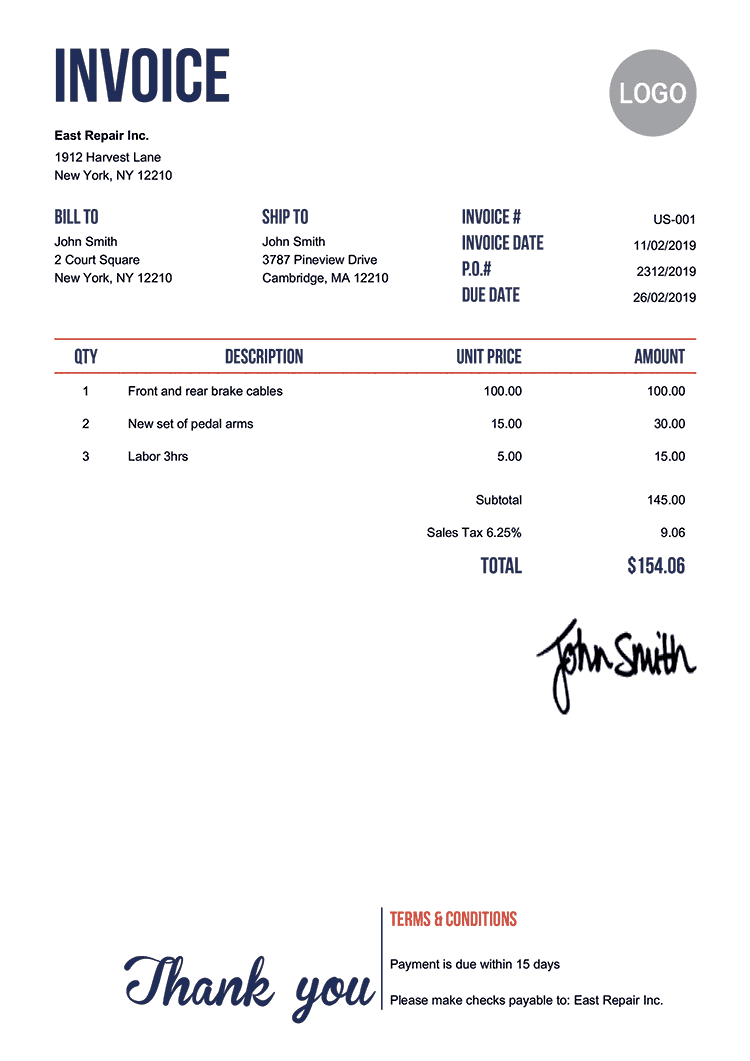

What is the name of the signer?
[{'end': 18.0, 'start': 17.0, 'answer': 'John Smith', 'score': 0.04398647323250771}]


In [6]:
image = download_image(
    "https://huggingface.co/spaces/impira/docquery/resolve/2359223c1837a7587402bda0f2643382a6eefeab/invoice.png"
)
display(image)

question = "What is the name of the signer?"
instances = [
    {"image": image_to_base64(image), "text": ""},
]
preds = endpoint.predict(instances=instances).predictions
print(question)
print(preds)

In [1]:
image = download_image(
    "https://huggingface.co/spaces/impira/docquery/resolve/2359223c1837a7587402bda0f2643382a6eefeab/invoice.png"
)
display(image)

question = "who is john smith?"
instances = [
    {"image": image_to_base64(image), "text": question},
]
preds = endpoint.predict(instances=instances).predictions
print(question)
print(preds)

NameError: name 'download_image' is not defined

### Clean up resources

In [ ]:
# Undeploy model and delete endpoint.
endpoint.delete(force=True)

# Delete models.
model.delete()